In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os




import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torch.utils.data import Dataset,DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor,Compose

import torchvision.transforms as T

# Data Loading: X -> Low SNR, y -> high SNR as matched in dataset_generator.py

In [2]:
def load_dataset(path):
    with np.load(path,allow_pickle=True) as data:
        X_train = data["X_train"]
        y_train = data["y_train"]
        X_test = data["X_test"]
        y_test = data["y_test"]
    return X_train,y_train,X_test,y_test


# General image in k-space handling function

# Normalization in K and Image space
### change the function in norm_dataset to act on pre processing normalizzation of data

In [3]:
from kspace_handling_functions import ifftnd,fftnd,rms_comb,do_image,plot_pair
from plotting_functions import *
from kspace_handling_functions import normalize_image,normalize_kspace_max,normalize_kspace_z,norm_dataset

# Standard Data generator: it loads an image, the reference image and apply custom transformazion in order

In [4]:
class proton_dataset(Dataset):
    def __init__(self, X, y, transform=None):
        
        s=X.shape
        X.shape == y.shape
        
        self.X = X.reshape((-1,s[2],s[3],s[4]))
        self.y = y.reshape((-1,s[2],s[3],s[4]))
        self.trans=transform
        self.tt = ToTensor()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        
        image = self.X[idx]
        label = self.y[idx]
        
        if self.trans:
            #image = np.expand_dims(image,axis=0)
            #tmp = np.concatenate((image,label),axis=0)
            image = self.trans(image)
            label = self.tt(label)

            #image, label = torch.split(tmp,1,dim=0)
            #label = self.trans(label)
       
        return image, label

In [5]:
#Checkpoints (to save model parameters during training)
class SaveBestModel:
    """utility to save the best performing model in validation during training."""
    def __init__(self, best_valid_loss=float('inf')): #object initialized with best_loss = +infinite
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion, metric,
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            # method to save a model (the state_dict: a python dictionary object that 
            # maps each layer to its parameter tensor) and other useful parametrers
            # see: https://pytorch.org/tutorials/beginner/saving_loading_models.html
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                'metric': metric,
                }, logs_params["weigths"])

# Data augmentation transformation:
 ## fourier -> geometric space 
 ## Transformation are applied in the geometric space using the standard pytorch package
 ##  geometric space ->fourier
 ## To apply the same transformation in both images and labels the two arrays are stacked, transformed and then splitted back

In [6]:
from data_transformation_and_augmentation import *

# Parameters for the experiment 
## Generation of the logs (results and parameters used to get them must always be logged)

In [40]:
#param training
train_params = {
    "max_epochs" : 100,
    "lr" : 3e-3,
    "milestones" : [30,80],
    "beta" : 0.5,
    "k-norm" : True,#normalization at volume level
    "zscore_example": False,#normalization at example level
    "do_train" : False,
    "accumulate" : True,
    
}
model_params = {
    "layers" : 11
    
}
# Parameters generator
generator_params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 32}

logs_params = {
    "weigths" : "new_model_exampe_normalized_beta05.pth"
}
# device setup
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

if train_params["accumulate"]==True:
    accumulation_steps = 3

# Load data and Initial normalization.
### As the first step always check the imported data and labels for inconsistencies

In [8]:
X_train,y_train,X_test,y_test = load_dataset("/workspace/data/proton_data_train_test.npz")

NORMALIZE=train_params["k-norm"]
if NORMALIZE:
    X_train = norm_dataset(X_train)
    y_train = norm_dataset(y_train)
    X_test = norm_dataset(X_test)
    y_test = norm_dataset(y_test)

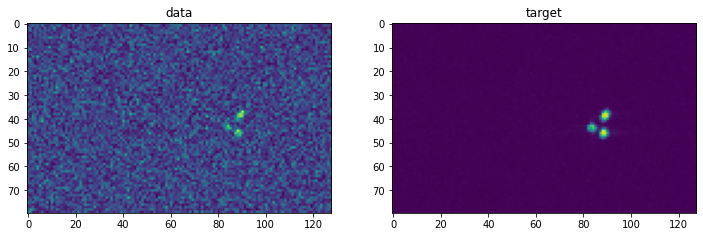

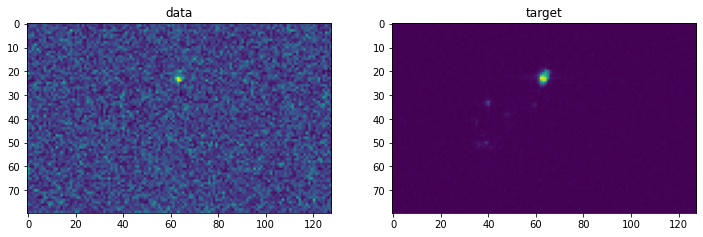

In [9]:
plot_pair(X_test,y_test,vol=10)
plot_pair(X_test,y_test,vol=15,fetta=6)

# Definition of the generators and data augmentation pipeline

In [10]:
# to M space
# transform
# back

import torchvision.transforms as T

transforms = nn.Sequential(# questo lo ripasso a sequential
    concatenateImageAndLabels(),
    T.RandomHorizontalFlip(p=0.1),
    T.RandomVerticalFlip(p=0.1),
    phase_multiplication(0.3,2*np.pi),
    FreqToSpace(),
    T.RandomHorizontalFlip(p=0.1),
    T.RandomVerticalFlip(p=0.1),
    #T.RandomRotation(15),
    prob_Rcrop(0.1),
    prob_PADcrop(0.1),
    T.RandomPerspective(distortion_scale=0.3, 
                     p=0.1, 
                     fill=0),
                
    prob_Affine(0.3),
    SpaceToFreq(),
    splitImageAndLabels(generator_params["batch_size"]),
    AddNoise_torch(0.02)
    #FreqToSpace()
)



# Array of transformation to be applied

batch shape  (228, 22, 1, 80, 256)
single image 2ch complex rep shape  torch.Size([2, 80, 256])


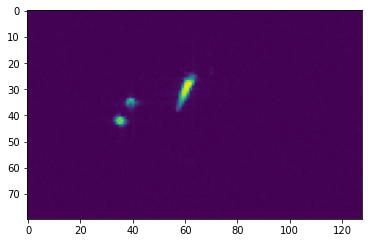

In [11]:
preprocessing =[ ToTensor()]
if train_params["zscore_example"]:
    preprocessing = preprocessing + [ norm_tensor()]

composed_train = Compose(preprocessing) 
composed_test = Compose(preprocessing)


print("batch shape ",y_train.shape)

loaded_image_test = composed_train(y_train[0,8,:,:,:])
print("single image 2ch complex rep shape ",loaded_image_test.shape)
loaded_image_test=loaded_image_test[0,:,:] +1j*loaded_image_test[1,:,:]
plt.imshow(do_image(loaded_image_test))

# Data generator and plotter utility

In [12]:
# Generators
training_set = proton_dataset(X_train, y_train,composed_train)
training_generator = DataLoader(training_set, **generator_params)

test_set = proton_dataset(X_test, y_test,composed_test)
test_generator = DataLoader(test_set, **generator_params)

sample = next(iter(training_generator))
print("gen out shape:",sample[1].shape)
print("gen out type:",sample[1].dtype)




print("transform out shape:",a.shape)
print("transform out type:",a.dtype)

gen out shape: torch.Size([64, 2, 80, 256])
gen out type: torch.float32
transform out shape: torch.Size([64, 2, 80, 256])
transform out type: torch.float32


64


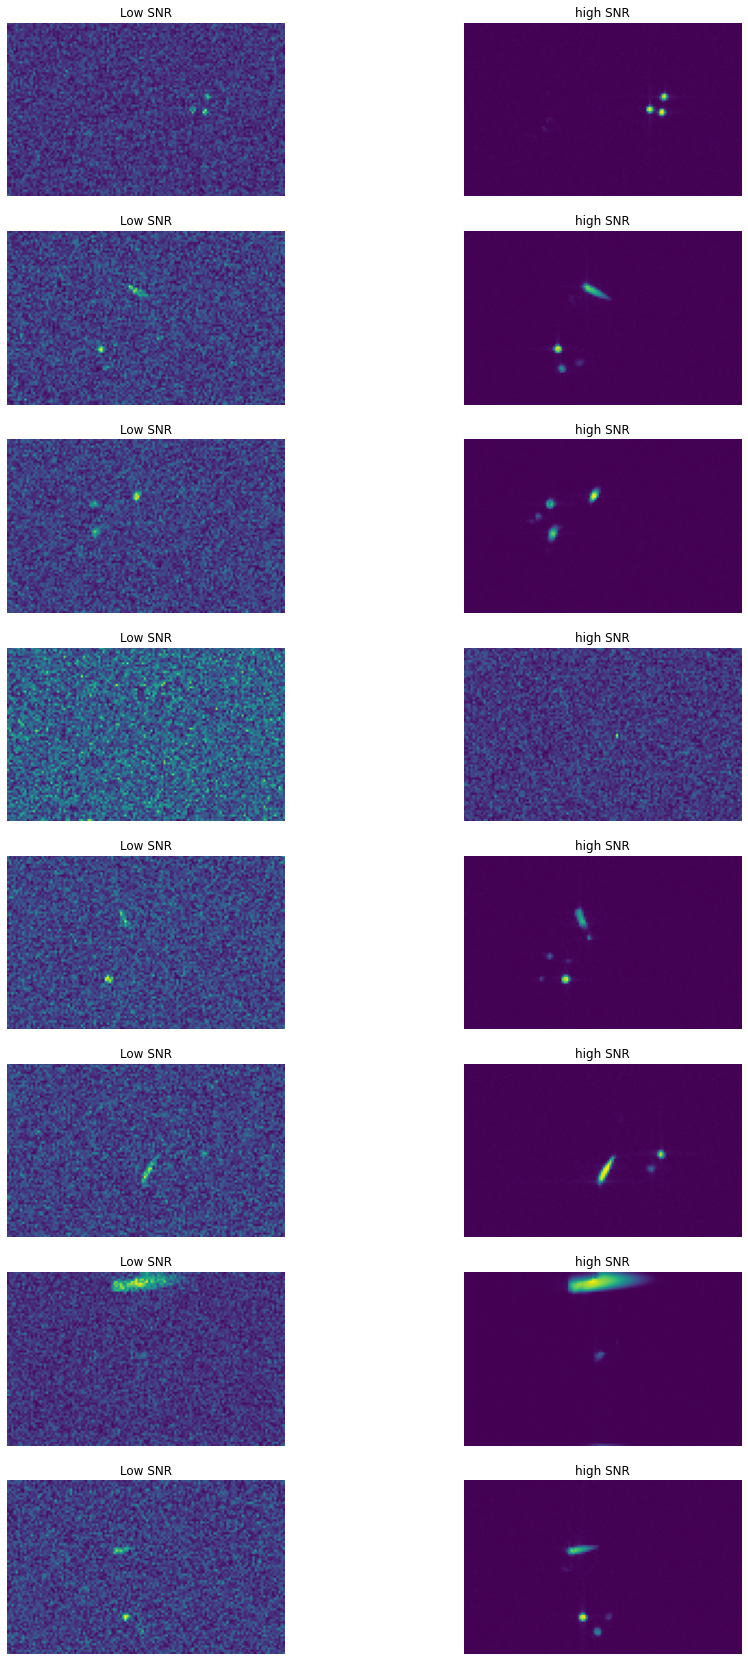

In [13]:
show_generator_output(sample)

64


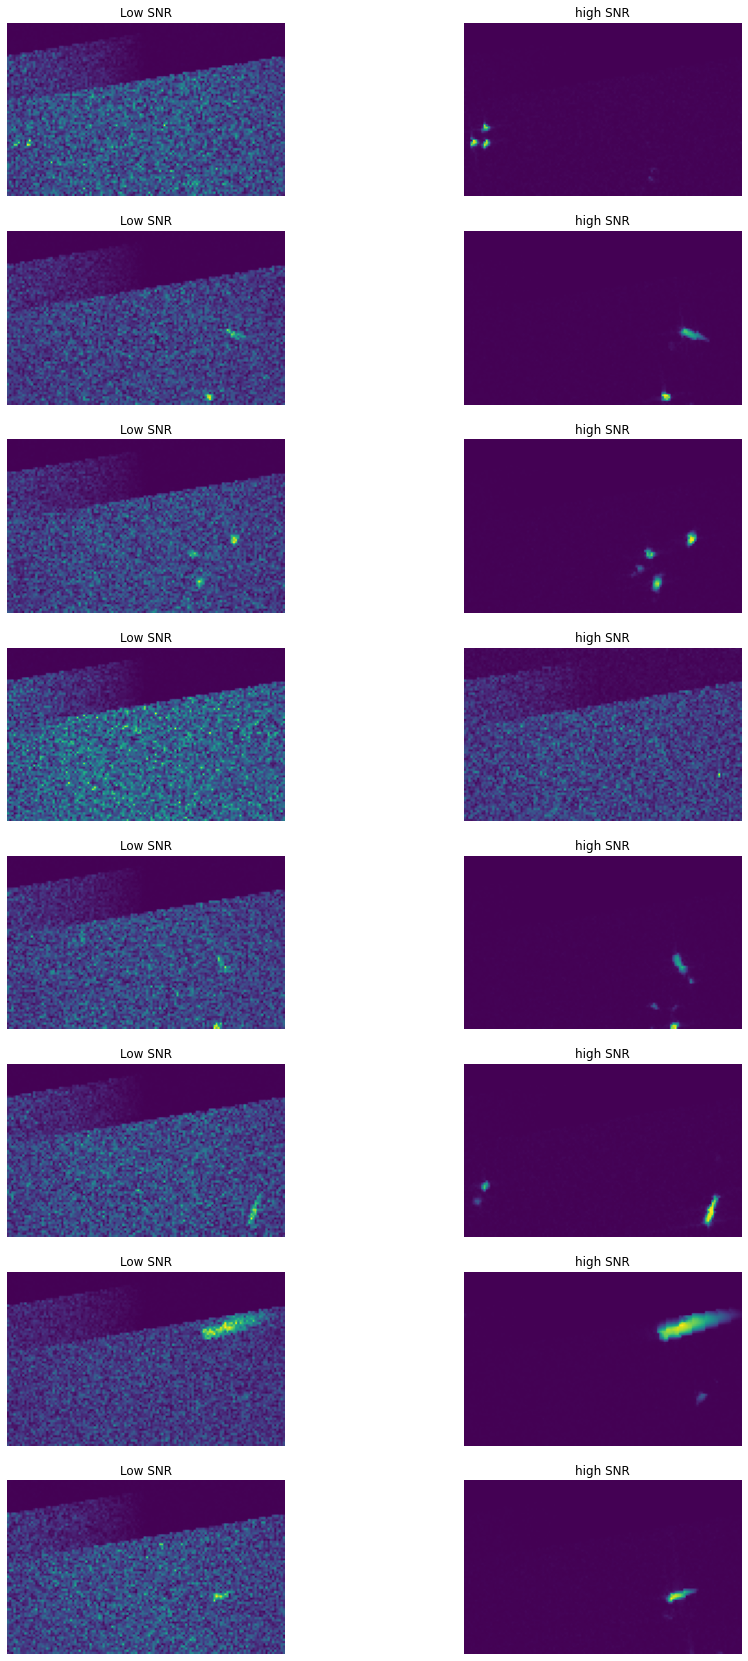

In [20]:
a,b = transforms(sample)
show_generator_output([a,b])

In [21]:
diff=np.abs(sample[0]-sample[1]).numpy()# difference between data and target
diff2=np.abs(a-b).numpy()# difference between data and target (trasformed)

Text(0.5, 1.0, 'difference between data and target (trasformed)')

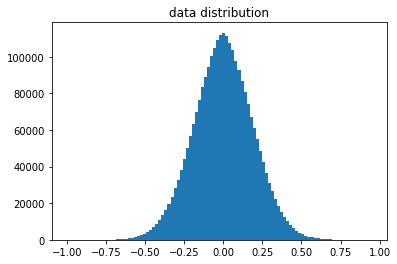

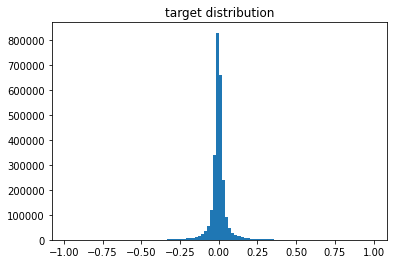

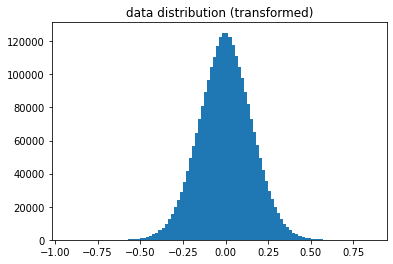

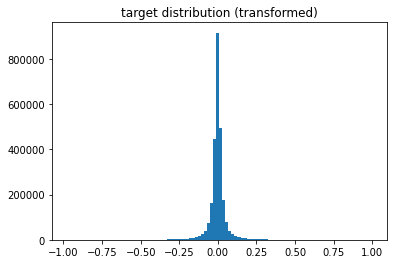

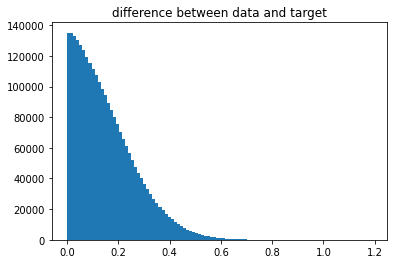

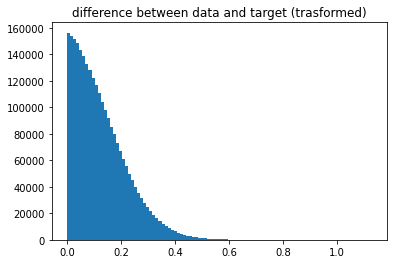

In [22]:
plt.figure()
_=plt.hist(sample[0].numpy().ravel(),100)
plt.title("data distribution")

plt.figure()
_=plt.hist(sample[1].numpy().ravel(),100)
plt.title("target distribution")

plt.figure()
_=plt.hist(a.numpy().ravel(),100)
plt.title("data distribution (transformed)")

plt.figure()
_=plt.hist(b.numpy().ravel(),100)
plt.title("target distribution (transformed)")
plt.figure()
_=plt.hist(diff.ravel(),100)
plt.title("difference between data and target")

plt.figure()
_=plt.hist(diff2.ravel(),100)
plt.title("difference between data and target (trasformed)")

In [31]:
from models import *

In [32]:
#model = DnCNN(2,num_of_layers=model_params["layers"],features = 32)
model = BRDNet()
# move the model into the GPU
model.to('cpu')
print('The model is in the: ', next(model.parameters()).device)
model.to(device)
print('now the model is in the: ', next(model.parameters()).device)
#!pip install torchsummary
from torchsummary import summary
if torch.cuda.is_available():
    summary(model.cuda(), input_size=(2,80,256))
else:
    summary(model, input_size=(2,80,256))

The model is in the:  cpu
now the model is in the:  cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 80, 256]           1,376
     BatchRenorm2d-2          [-1, 32, 80, 256]              64
              ReLU-3          [-1, 32, 80, 256]               0
            Conv2d-4          [-1, 32, 80, 256]          21,536
     BatchRenorm2d-5          [-1, 32, 80, 256]              64
              ReLU-6          [-1, 32, 80, 256]               0
            Conv2d-7          [-1, 32, 80, 256]          21,536
     BatchRenorm2d-8          [-1, 32, 80, 256]              64
              ReLU-9          [-1, 32, 80, 256]               0
           Conv2d-10          [-1, 32, 80, 256]          21,536
    BatchRenorm2d-11          [-1, 32, 80, 256]              64
             ReLU-12          [-1, 32, 80, 256]               0
           Conv2d-13          [-1, 32, 80, 2

# Test image conversion in pytorch

# Mixed Loss definition:
 - both kspace difference and magnitude image are computed in loss.

In [33]:
#!pip install kornia

In [34]:
from kornia.losses import SSIMLoss,MS_SSIMLoss
class MixedLoss(nn.Module):
    def __init__(self, beta=0.1, weight=None, size_average=True,SSIM_flag=False):
        super(MixedLoss, self).__init__()
        
        self.pool2D=torch.nn.AvgPool2d([1,2],stride=[1,2],divisor_override=2)
        
        self.MSEloss = nn.MSELoss()
        
        if SSIM_flag == True :
            self.im_loss = MS_SSIMLoss()
            
        else:
            self.im_loss = nn.MSELoss()
            
        
        
        self.beta=beta
        
 
    def forward(self, k_pred,im_pred, targets):     
        
        z = self.pool2D(targets)# subsample
        z = torch.complex(z[:,0,:,:], z[:,1,:,:])
        #print(z.dtype)
        z = torch.unsqueeze(z,dim=1)
        #print(z.dtype)
        im = torch.fft.fftshift( torch.fft.ifft2( torch.fft.ifftshift(z,dim=[-2,-1] ),norm="ortho" ),dim=[-2,-1]).abs()

        
        #im=torch.nn.functional.normalize(im, p=2.0, dim=[0])# normalized GT image # controllare se va messo
        #im_pred=torch.nn.functional.normalize(im_pred, p=2.0, dim=[0])# normalized prediction
        
        im_loss = self.im_loss(im_pred, im)
        
        k_loss = self.MSEloss(k_pred,targets)
        
        return (1-self.beta)*k_loss + self.beta*im_loss

In [35]:
loss_func = MixedLoss(beta=train_params["beta"],SSIM_flag=True).to(device) #binary cross entropy loss
from torch import optim
opt = optim.Adam(model.parameters(), lr=train_params["lr"])
scheduler = optim.lr_scheduler.MultiStepLR(opt, milestones=train_params["milestones"], gamma=0.1)

In [36]:


metric_func = nn.MSELoss()


In [37]:
train_params["do_train"]

False

In [38]:
#training loop
TRAIN=train_params["do_train"]
#model.load_state_dict(torch.load(logs_params["weigths"])['model_state_dict'])
#model.to(device)
if TRAIN:
    
    transforms.to(device)
    import time

    save_best_model = SaveBestModel()

    # lists to save loss and metric history
    hist_loss = []
    hist_metric = []
    hist_vloss = []
    hist_vmetric = []

    #loop over epochs
    for epoch in range(train_params["max_epochs"]):
       
        t0 = time.time()

        #training step
        model.train()

        train_loss = 0.0
        train_metric = 0.0
        counter = 0
        for xb, yb in training_generator: #takes a batch from the train dataloader 
            counter += 1 
            xb=xb.type(torch.float).to(device) #move troch tensors to device (cpu or GPU)
            yb=yb.type(torch.float).to(device)
            
            xb,yb = transforms([xb,yb])

            pred_k,pred_im = model(xb) #get prediction for batch
            loss = loss_func(pred_k,pred_im, yb) #compute loss
            metric = metric_func(pred_k, yb) #compute metric
            
            if train_params["accumulate"] == True:
                loss=loss/accumulation_steps
            
            train_loss += loss.item() #update total loss
            train_metric += metric.item() #update total metric

            # backpropagation
            loss.backward()
             # This guaranties that total loss doesn't bring some immediate buffers with it #https://gist.github.com/thomwolf/ac7a7da6b1888c2eeac8ac8b9b05d3d3
            pred_k.detach_()
            pred_im.detach_()
            loss.detach_()
            
            if train_params["accumulate"] == False:# accumulate gradients in minibatches. test with small bacth (also for colab conversion)
                
                opt.step()
                opt.zero_grad()
            elif (counter+1) % accumulation_steps == 0: 
                # update weights
                opt.step()
                # set to zero gradients for the next step
                opt.zero_grad()

        # normalize loss and metric by number of batches
        train_loss = train_loss/counter
        train_metric = train_metric/counter

        # update history
        hist_loss.append(train_loss)
        hist_metric.append(train_metric)


        # evaluation setp (same as trainign but w/o backpropagation)
        model.eval()

        vali_loss = 0.0
        vali_metric = 0.0
        counter = 0
        with torch.no_grad():
            for xb, yb in test_generator:
                counter += 1
                xb=xb.type(torch.float).to(device)
                yb=yb.type(torch.float).to(device)
                pred_k,pred_im = model(xb)
                vloss = loss_func(pred_k,pred_im, yb)
                if train_params["accumulate"] == True:
                    vloss=vloss/accumulation_steps
                vmetric = metric_func(pred_k, yb)
                vali_loss += vloss.item()
                vali_metric += vmetric.item()

        vali_loss = vali_loss/counter
        vali_metric = vali_metric/counter    

        hist_vloss.append(vali_loss)
        hist_vmetric.append(vali_metric)

        #save best model
        save_best_model(vali_loss, epoch, model, opt, loss_func, metric_func)   

        elapsed_time = time.time()-t0
        print("epoch: %d, time(s): %.4f, train loss: %.6f, train metric: %.6f, vali loss: %.6f, vali metric: %.6f" % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric))

        # update learning rate schedule
        scheduler.step()
    plt.figure(figsize=(10, 7))
    plt.subplot(1,2,1)
    plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
    plt.plot(range(1,len(hist_vloss)+1), hist_vloss, color='blue', linestyle='-', label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale("log")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(range(1,len(hist_metric)+1), hist_metric,  color='green', linestyle='-', label='train metric')
    plt.plot(range(1,len(hist_vmetric)+1),hist_vmetric, color='blue', linestyle='-', label='validation metric')
    plt.xlabel('Epochs')
    plt.ylabel('Metric')
    plt.yscale("log")
    plt.legend()
    plt.savefig("training.jpg")
else:
    #model.load_state_dict(torch.load('best_model.pth')['model_state_dict'])
    #model.eval()
    print("train skipped")

train skipped


In [41]:

_ = model.load_state_dict(torch.load(logs_params["weigths"])['model_state_dict'])
model.eval()

BRDNet(
  (upnet): UpNet(
    (net): Sequential(
      (0): Conv2d(2, 32, kernel_size=[3, 7], stride=(1, 1), padding=(1, 3))
      (1): BatchRenorm2d()
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=[3, 7], stride=(1, 1), padding=(1, 3))
      (4): BatchRenorm2d()
      (5): ReLU()
      (6): Conv2d(32, 32, kernel_size=[3, 7], stride=(1, 1), padding=(1, 3))
      (7): BatchRenorm2d()
      (8): ReLU()
      (9): Conv2d(32, 32, kernel_size=[3, 7], stride=(1, 1), padding=(1, 3))
      (10): BatchRenorm2d()
      (11): ReLU()
      (12): Conv2d(32, 32, kernel_size=[3, 7], stride=(1, 1), padding=(1, 3))
      (13): BatchRenorm2d()
      (14): ReLU()
      (15): Conv2d(32, 32, kernel_size=[3, 7], stride=(1, 1), padding=(1, 3))
      (16): BatchRenorm2d()
      (17): ReLU()
      (18): Conv2d(32, 32, kernel_size=[3, 7], stride=(1, 1), padding=(1, 3))
      (19): BatchRenorm2d()
      (20): ReLU()
      (21): Conv2d(32, 32, kernel_size=[3, 7], stride=(1, 1), padding=(1, 3))
      (22

In [42]:
test_sample,test_label = next(iter(test_generator))
model.to('cpu')
pred = model(test_sample)


64
0.012298192270100117
0.4461802840232849


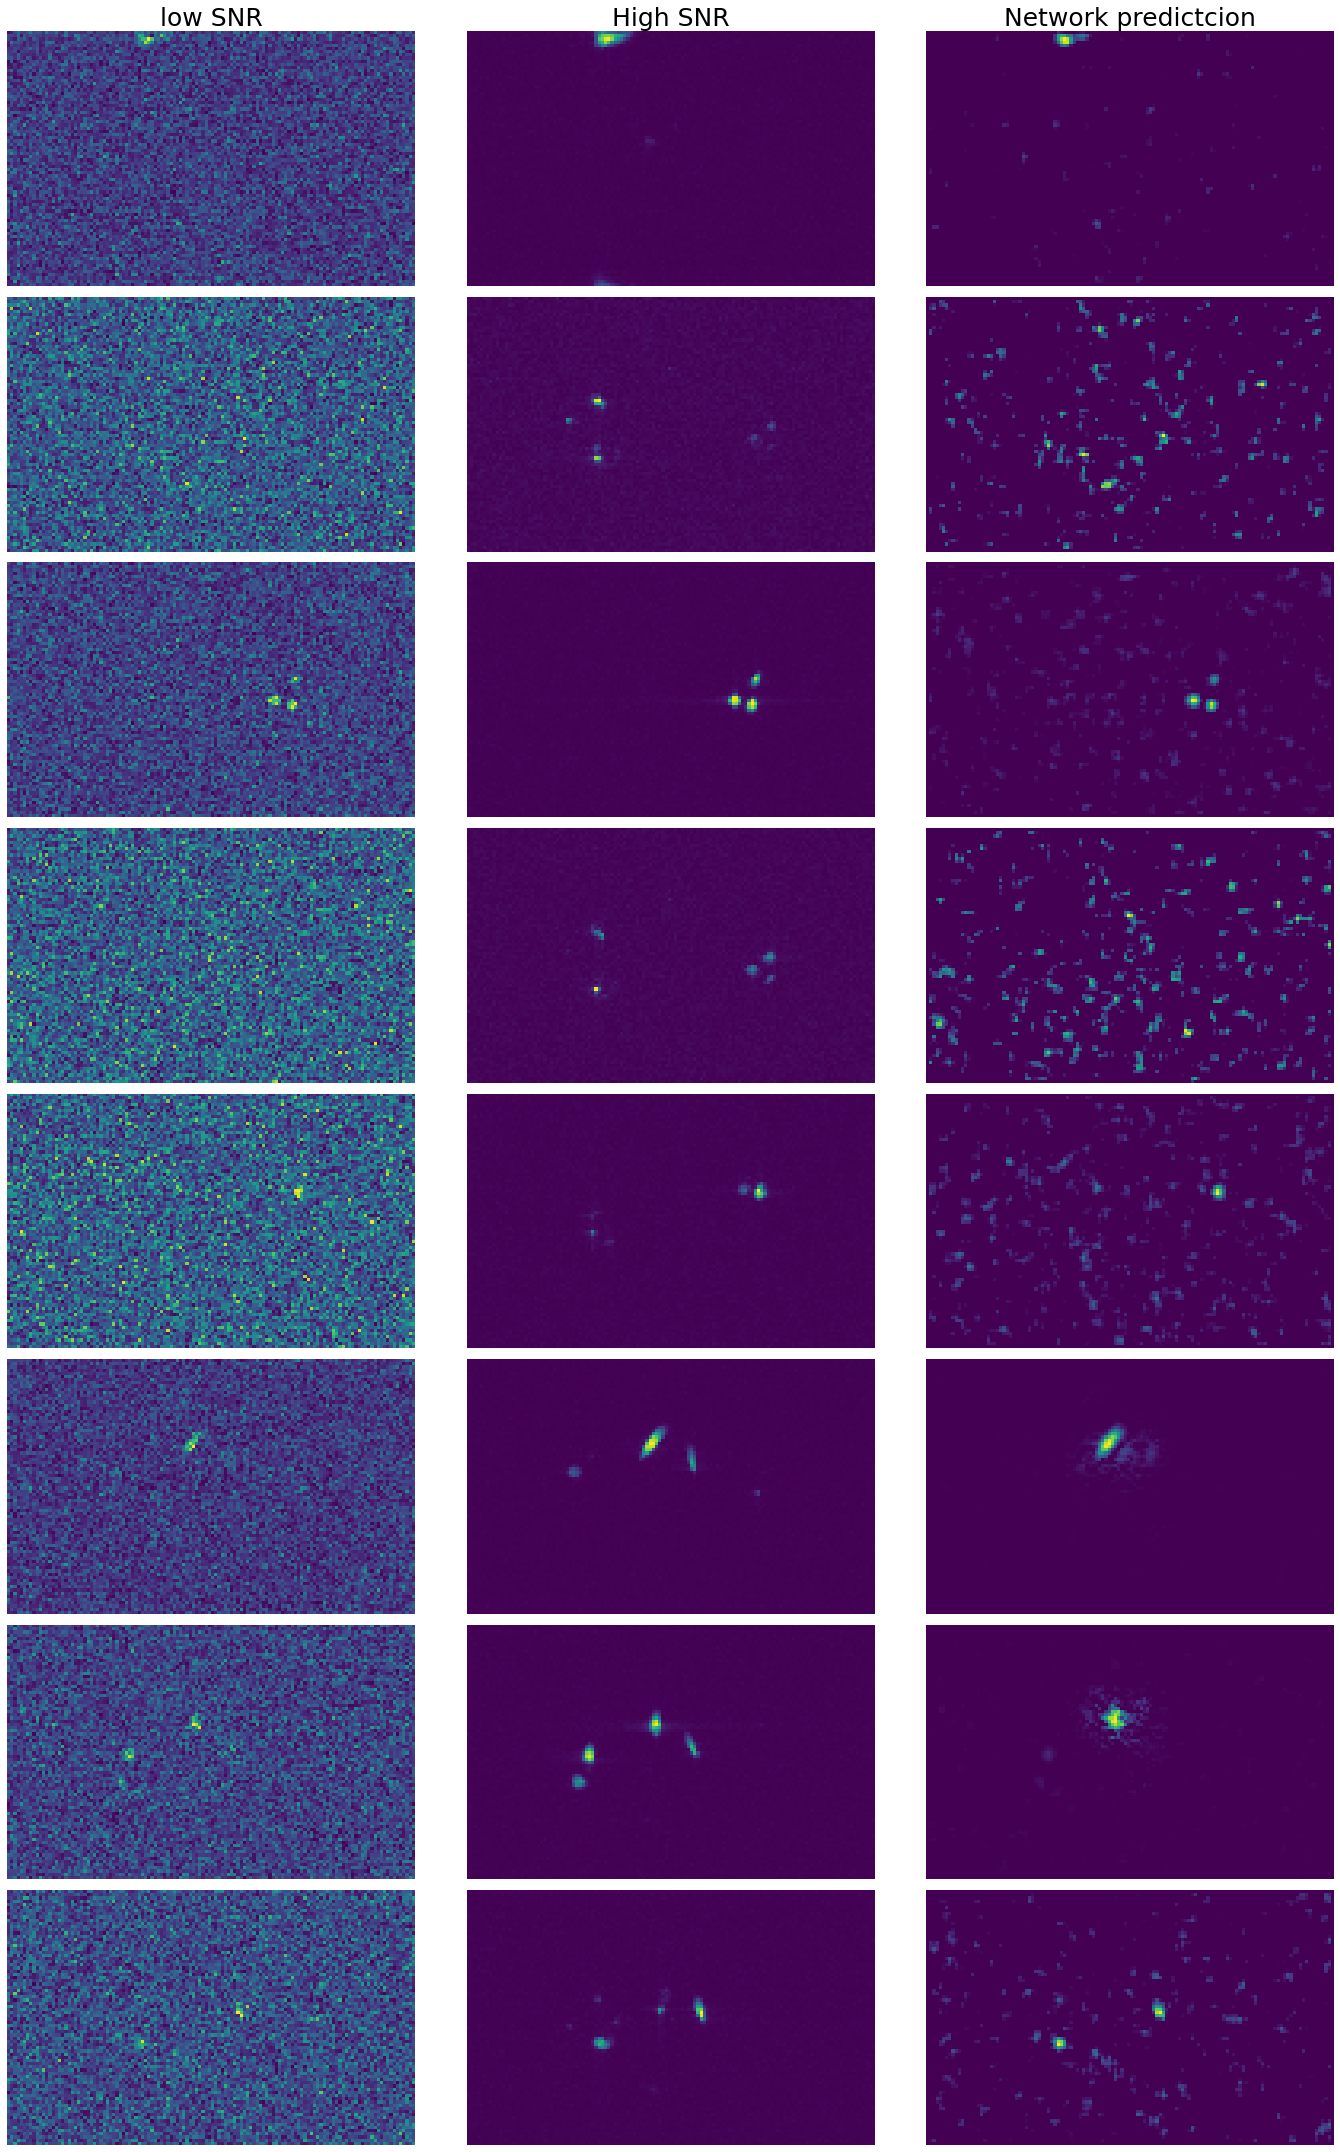

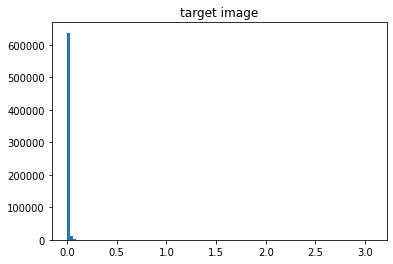

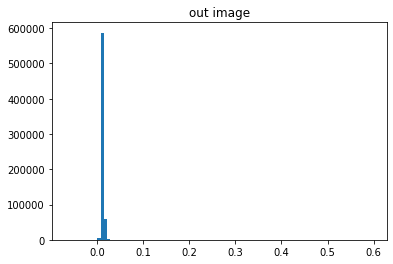

In [43]:
show_pred_batch([test_sample,test_label],pred)